# Bikes

In [1]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
bikes = pd.read_csv("bikes.csv")
bikes["hour_sin"] = np.sin(bikes.hour * np.pi / 12)
bikes["hour_cos"] = np.cos(bikes.hour * np.pi / 12)

data = bikes[["count", "hour_sin", "hour_cos", "temperature", "humidity", "windspeed"]]

We define a linear model using Bambi's syntax, where "hour" is the response variables and "hour", "temperature", "humidity" and "windspeed" are the covariates

In [4]:
model = bmb.Model(
    "count ~ hour_sin + hour_cos + temperature + humidity + windspeed", data=data
)

By default Bambi use a Gaussian likelihood with normal priors for the coeeficients in the linear term and a Half-Student t for sigma 

In [5]:
model

       Formula: count ~ hour_sin + hour_cos + temperature + humidity + windspeed
        Family: gaussian
          Link: mu = identity
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 192.227, sigma: 2106.8107)
            hour_sin ~ Normal(mu: 0.0, sigma: 648.8377)
            hour_cos ~ Normal(mu: 0.0, sigma: 648.0963)
            temperature ~ Normal(mu: 0.0, sigma: 2363.053)
            humidity ~ Normal(mu: 0.0, sigma: 2428.6856)
            windspeed ~ Normal(mu: 0.0, sigma: 3961.1844)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 183.4114)

We fit the model. This is calling `pm.sample()` under the hood.

In [6]:
idata = model.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [count_sigma, Intercept, hour_sin, hour_cos, temperature, humidity, windspeed]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Now we use Kulrprit to perform variable selection via projective prediction. In a nutshell we use the fitted model as the reference model, and we look to identify subsets of its parameters that achieve similar predictive performance.

In [7]:
ref_model = kpt.ProjectionPredictive(model, idata)
ref_model.search()

Starting from the intercept-only model up to all covariables, which variables we should include to get better and better predictions?

In [8]:
for value in ref_model.path.values():
    print(value.model.formula)

Formula(count ~ 1)
Formula(count ~ hour_cos)
Formula(count ~ hour_cos + hour_sin)
Formula(count ~ hour_cos + hour_sin + temperature)
Formula(count ~ hour_cos + hour_sin + temperature + humidity)
Formula(count ~ hour_cos + hour_sin + temperature + humidity + windspeed)


We can also evaluate the submodels in terms of LOO

/home/pablo/anaconda3/envs/bart-variables/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/pablo/anaconda3/envs/bart-variables/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


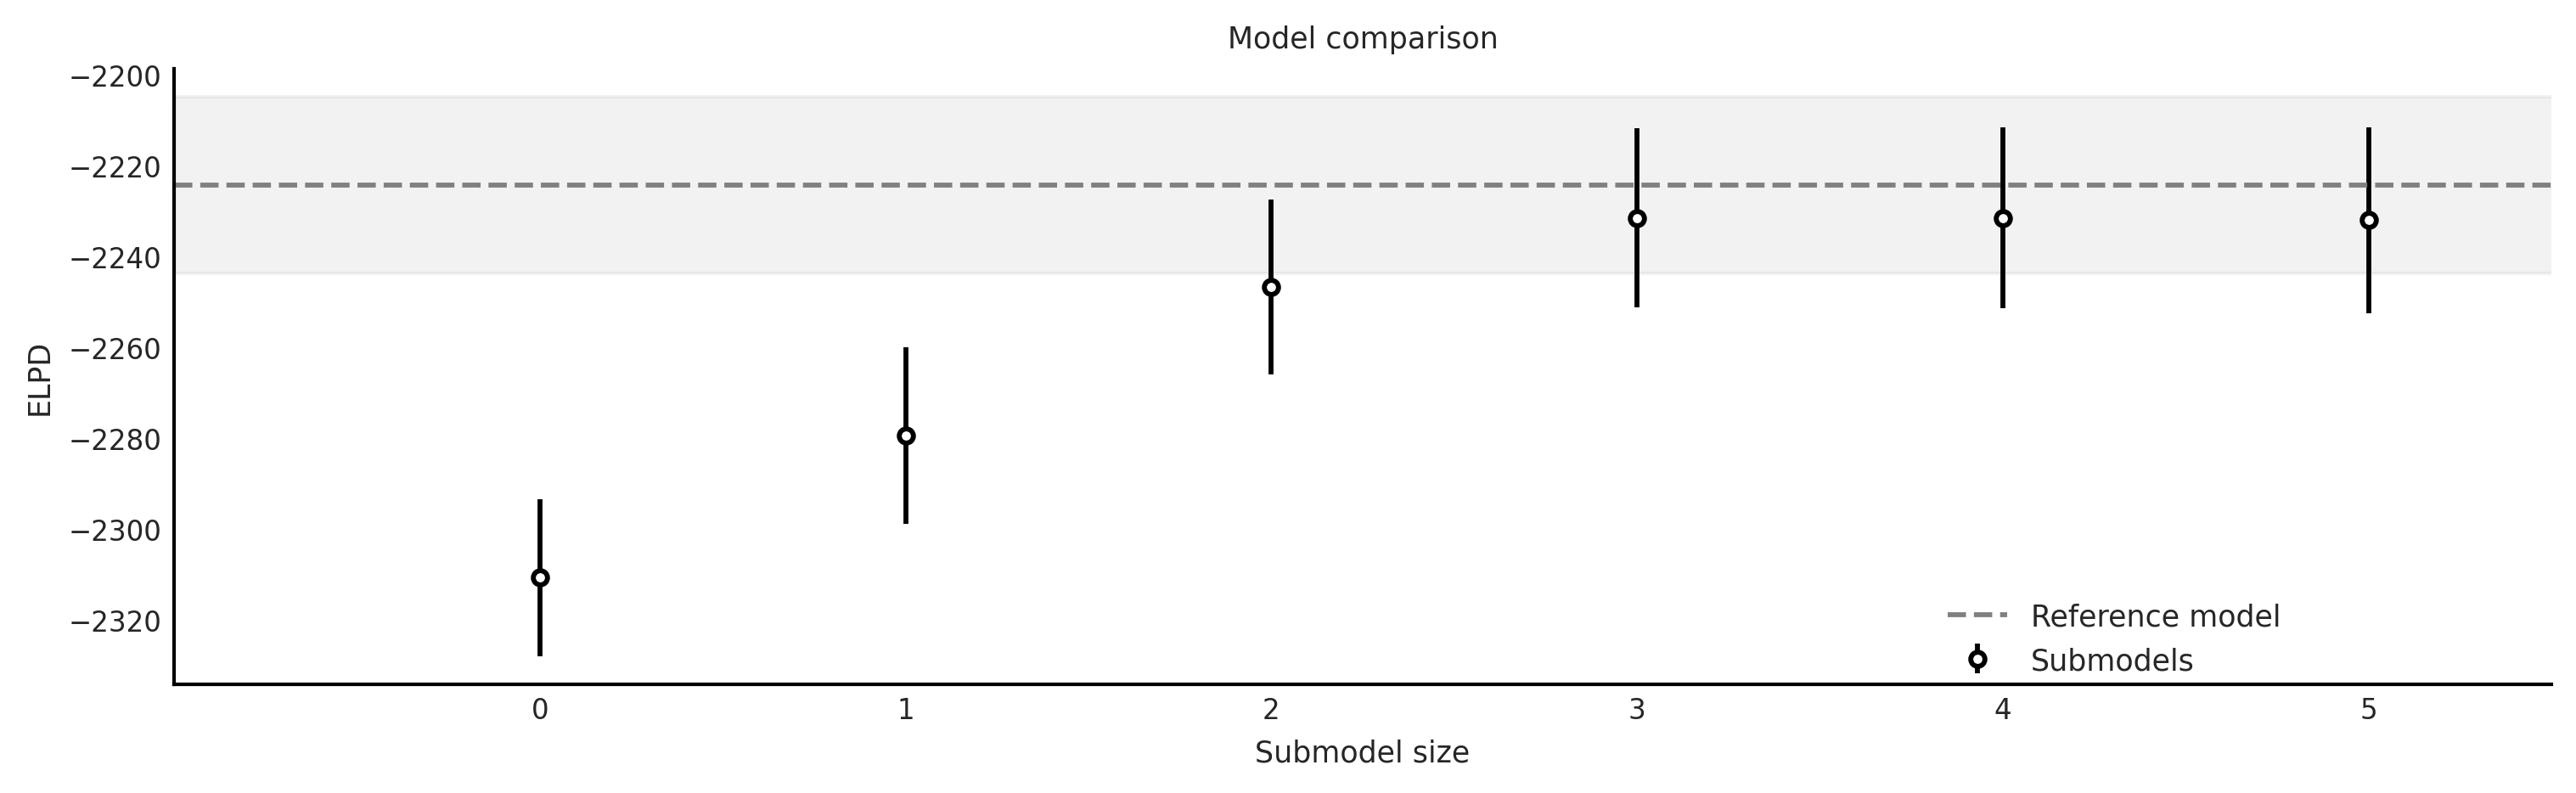

In [9]:
cmp, ax = ref_model.plot_compare(plot=True, figsize=(10, 3));